In [8]:
import pandas as pd
import json
import requests
from math import cos, radians
import matplotlib.pyplot as plt
import numpy as np
import os

**Input CSV File and GeoJSON File Paths here:**


In [9]:
CSV_FILE = 'bus1_busdata.csv'
GEOJSON_FILE = 'data_routes/patong_bus1_bus2_ordered.geojson'

ORDERS_PER_KM = 200

In [12]:
def load_route_coords(file):
    """Loads route coordinates and their order index from a GeoJSON file."""
    try:
        with open(file, "r") as f:
            geojson = json.load(f)
        
        # Extract (order, longitude, latitude) tuples for route points
        return [
            (feat["properties"]["order"],
             feat["geometry"]["coordinates"][0],
             feat["geometry"]["coordinates"][1])
            for feat in geojson["features"] if 'order' in feat["properties"]
        ]
    except FileNotFoundError:
        print(f"Error: Route GeoJSON file not found at {file}")
        return []
    except Exception as e:
        print(f"Error loading GeoJSON: {e}")
        return []

In [13]:
def map_index(route_coords, bus_pos):
    """
    Maps a bus's [lon, lat] position to the nearest 'order' index on the route.
    Uses the great-circle approximation for distance calculation.
    """
    if not route_coords or not bus_pos or len(bus_pos) < 2:
        return None

    min_dist = float("inf")
    nearest_index = None
    bus_lon, bus_lat = bus_pos
    
    # Pre-calculate cos(latitude) for faster x-distance approximation
    cos_lat = cos(radians(bus_lat)) 

    # Coefficients for converting degree differences to meters (at the equator)
    M_PER_DEG_LON = 111320 
    M_PER_DEG_LAT = 110540

    for order, lon, lat in route_coords:
        # Approximate distance squared (d2) using Euclidean distance on a flat map (fast)
        dx = (lon - bus_lon) * M_PER_DEG_LON * cos_lat 
        dy = (lat - bus_lat) * M_PER_DEG_LAT
        d2 = dx * dx + dy * dy
        
        if d2 < min_dist:
            min_dist = d2
            nearest_index = order

    return nearest_index


Extracting position and speed data...
Mapping bus positions to route order index...
Calculating average speed for each 1 km interval...
    km_interval  avg_speed  count  km_label
0             0  19.305819    739    KM 0-1
1             1  18.648769   3818    KM 1-2
2             2  17.452748   3894    KM 2-3
3             3  15.236436   4534    KM 3-4
4             4  18.098108   2273    KM 4-5
5             5  19.300809   4202    KM 5-6
6             6  28.994301   2632    KM 6-7
7             7  25.892210   2978    KM 7-8
8             8  38.433097   1831    KM 8-9
9             9  35.187325   2146   KM 9-10
10           10  34.122745   2273  KM 10-11
11           11  48.264975   1419  KM 11-12
12           12  25.275823   2672  KM 12-13
13           13  17.315489   3325  KM 13-14
14           14  22.266454   2826  KM 14-15
15           15  25.528519   2700  KM 15-16
16           16  26.013177   2049  KM 16-17
17           17  24.544171   1786  KM 17-18
18           18   6.403850  

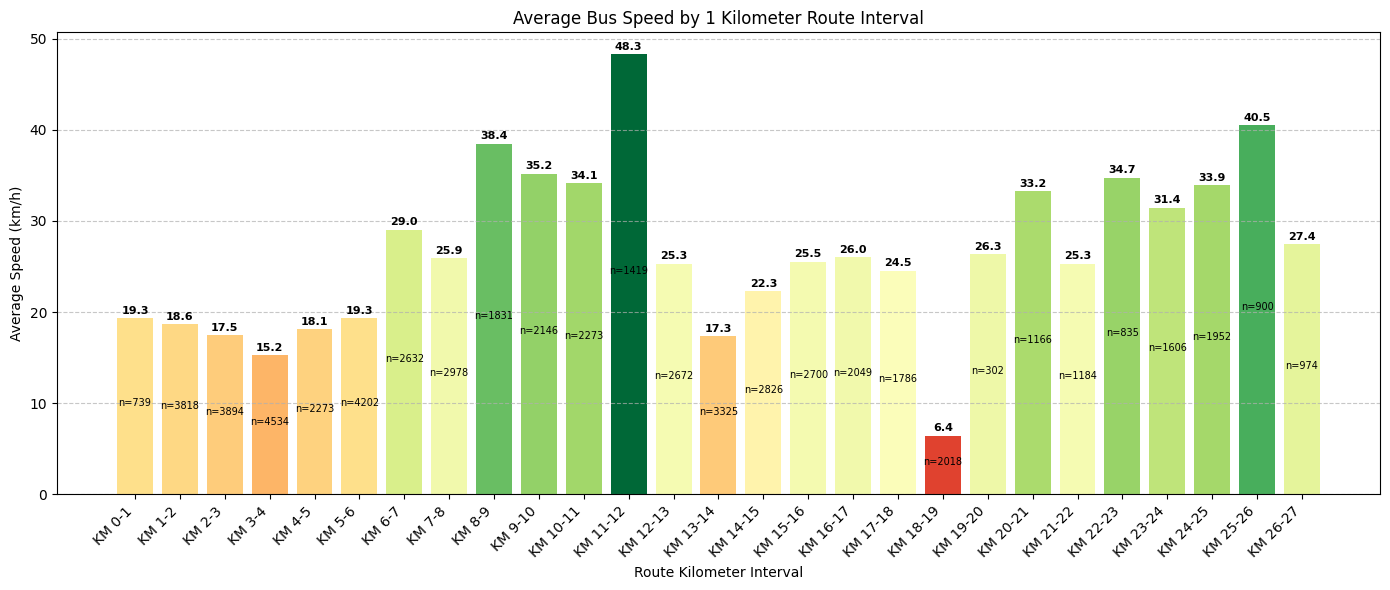

In [14]:
# ==== ANALYSIS FUNCTION ====

def analyze_speed_by_kilometer(csv_file, geojson_file):
    """
    Performs speed analysis by mapping bus positions to route kilometers.
    """
    try:
        # 1. Load Data and Route Coordinates
        df = pd.read_csv(csv_file)
        route_coords = load_route_coords(geojson_file)
        
        if route_coords is None or not route_coords:
             print("Analysis stopped: Could not load route coordinates.")
             return
             
    except Exception as e:
        print(f"Error loading CSV file: {e}")
        return

    # 2. Extract Speed (spd) and Position (pos) from the JSON 'data' column
    print("Extracting position and speed data...")
    def parse_data(json_str):
        try:
            # Handle possible extra quotes or formatting issues by cleaning the string
            data = json.loads(json_str.replace('""', '"'))
            return pd.Series({
                'spd': data.get('spd', 0),
                'pos': data.get('pos')
            })
        except:
            return pd.Series({'spd': None, 'pos': None})

    df[['spd', 'pos']] = df['data'].apply(parse_data)
    
    # Filter out records where speed or position could not be parsed
    df = df.dropna(subset=['spd', 'pos'])
    df = df[df['spd'] > 0].copy()
    
    if df.empty:
        print("Analysis stopped: No valid speed and position data found after parsing.")
        return

    # 3. Map Position to Route Order Index
    print("Mapping bus positions to route order index...")
    # Use the map_index utility function to find the nearest route point (order)
    df['order'] = df['pos'].apply(lambda p: map_index(route_coords, p))

    # Filter out buses that could not be mapped to the route
    df.dropna(subset=['order'], inplace=True)
    df['order'] = df['order'].astype(int)

    if df.empty:
        print("Analysis stopped: No bus positions could be mapped to the route.")
        return
        
    # 4. Create 1 km Intervals (based on 200 orders per km)
    # Integer division gives us the kilometer bin index (e.g., 0-199 -> 0, 200-399 -> 1)
    df['km_interval'] = (df['order'] / ORDERS_PER_KM).astype(int)
    
    # Create a cleaner label for the plot
    df['km_label'] = df['km_interval'].apply(lambda x: f"KM {x}-{x+1}")
    
    # 5. Group and Calculate Average Speed
    print("Calculating average speed for each 1 km interval...")
    analysis_df = df.groupby('km_interval').agg(
        avg_speed=('spd', 'mean'),
        count=('spd', 'count'),
        km_label=('km_label', 'first')
    ).reset_index()

    # Sort by the interval index
    analysis_df = analysis_df.sort_values(by='km_interval')

    print(analysis_df)

    # save analysis_df to csv
    analysis_df.to_csv('data_speeds/bus1_speeds.csv')
    
    print(f"Analysis Complete. Found {len(analysis_df)} kilometer intervals with data.")
    print("--- Top 5 Segments by Average Speed ---")
    print(analysis_df[['km_label', 'avg_speed', 'count']].sort_values(by='avg_speed', ascending=False).head())

    # 6. Plot the Graph
    plt.figure(figsize=(14, 6))
    
    # Set bar color based on speed (optional, for better visualization)
    colors = plt.cm.RdYlGn(analysis_df['avg_speed'] / analysis_df['avg_speed'].max())
    
    bars = plt.bar(analysis_df['km_label'], analysis_df['avg_speed'], color=colors)
    
    plt.title('Average Bus Speed by 1 Kilometer Route Interval')
    plt.xlabel('Route Kilometer Interval')
    plt.ylabel('Average Speed (km/h)')
    
    # Rotate x-axis labels for readability
    plt.xticks(rotation=45, ha='right')
    
    # Add labels showing the exact speed and count above each bar
    for bar, speed, count in zip(bars, analysis_df['avg_speed'], analysis_df['count']):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.5, 
                 f"{speed:.1f}", ha='center', fontsize=8, weight='bold')
        # Add a secondary label for the count (number of data points)
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() / 2, 
                 f"n={count}", ha='center', fontsize=7, color='black')

    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Execute the analysis
if __name__ == "__main__":
    analyze_speed_by_kilometer(CSV_FILE, GEOJSON_FILE)

In [15]:
import pandas as pd

df = pd.read_csv("data_speeds/airport_rawai_speeds.csv")

# reverse only avg_speed values
df["avg_speed"] = df["avg_speed"].iloc[::-1].reset_index(drop=True)

# (optional) save to new file
df.to_csv("data_speeds/rawai_airport_speeds.csv", index=False)

print(df)

    Unnamed: 0  km_interval  avg_speed  count  km_label
0            0            0  18.172414   3546    KM 0-1
1            1            1  30.934343   2726    KM 1-2
2            2            2  27.601173   1614    KM 2-3
3            3            3  29.079845    965    KM 3-4
4            4            4  39.172840    834    KM 4-5
5            5            5  29.758765   1151    KM 5-6
6            6            6  29.646507   1262    KM 6-7
7            7            7  37.823944    570    KM 7-8
8            8            8  22.385881     95    KM 8-9
9            9            9  20.521739   1186   KM 9-10
10          10           10  20.589560    838  KM 10-11
11          11           11  32.255161    786  KM 11-12
12          12           12  24.886231   1562  KM 12-13
13          13           13  28.343060    947  KM 13-14
14          14           14  40.589286   1390  KM 14-15
15          15           15  37.336792   1153  KM 15-16
16          16           16  46.830275   1175  K